# Decision trees and Random Forest with scikit-learn 📊📊

Let's train a decision tree and a random forest on our toy-dataset.

## What will you learn in this course? 🧐🧐
This lecture is a follow-along demo that will guide you through the steps of building decision trees / random forest models and evaluate them on actual data.

* Preprocessing
    * Training pipeline
    * Test pipeline
* Decision tree
    * Training with hyperparameter optimization
    * Performances
* Random forest
    * Training with hyperparameter optimization
    * Performances

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("src/Data.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])


Number of rows : 10

Display of dataset: 


,Country,Age,Salary,Purchased
0,France,44.0,72000,No
1,Spain,27.0,48000,Yes
2,Germany,30.0,54000,No
3,Spain,38.0,61000,No
4,Germany,40.0,69000,Yes



Basics statistics: 


,Country,Age,Salary,Purchased
count,10,9.000000,10.000000,10
unique,3,NaN,NaN,2
top,France,NaN,NaN,No
freq,4,NaN,NaN,5
mean,NaN,38.777778,64300.000000,NaN
std,NaN,7.693793,11681.419244,NaN
min,NaN,27.000000,48000.000000,NaN
25%,NaN,35.000000,55000.000000,NaN
50%,NaN,38.000000,64000.000000,NaN
75%,NaN,44.000000,71250.000000,NaN



Percentage of missing values: 


Country       0.0
Age          10.0
Salary        0.0
Purchased     0.0
dtype: float64

## Preprocessing

In [4]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Purchased"

X = dataset.drop(target_variable, axis = 1)
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X :
   Country   Age  Salary
0   France  44.0   72000
1    Spain  27.0   48000
2  Germany  30.0   54000
3    Spain  38.0   61000
4  Germany  40.0   69000


In [5]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Age', 'Salary']
Found categorical features  ['Country']


In [6]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



:::tip No need to normalize the numeric features!
Decision trees are not sensitive at all to the scale of the input features. So, if you plan to use only decision-tree-based algorithms, you can just skip the standardization step! The model's convergence time won't be deteriorated, neither will the computation of the features' importances.
:::

In [7]:
# Create pipeline for numeric features
numeric_transformer = SimpleImputer(strategy='mean') # missing values will be replaced by columns' mean

In [8]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [9]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
   Country   Age  Salary
0   France  44.0   72000
4  Germany  40.0   69000
6    Spain   NaN   52000
9   France  37.0   67000
3    Spain  38.0   61000
...Done.
[[4.40000000e+01 7.20000000e+04 0.00000000e+00 0.00000000e+00]
 [4.00000000e+01 6.90000000e+04 1.00000000e+00 0.00000000e+00]
 [3.58571429e+01 5.20000000e+04 0.00000000e+00 1.00000000e+00]
 [3.70000000e+01 6.70000000e+04 0.00000000e+00 0.00000000e+00]
 [3.80000000e+01 6.10000000e+04 0.00000000e+00 1.00000000e+00]]

Encoding labels...
0     No
4    Yes
6     No
9    Yes
3     No
Name: Purchased, dtype: object
...Done
[0 1 0 1 0]
Performing preprocessings on test set...
   Country   Age  Salary
8  Germany  50.0   83000
7   France  48.0   79000
...Done.
[[5.0e+01 8.3e+04 1.0e+00 0.0e+00]
 [4.8e+01 7.9e+04 0.0e+00 0.0e+00]]

Encoding labels...
8     No
7    Yes
Name: Purchased, dtype: object
...Done
[0 1]


## Decision tree
Let's train a decision tree (with hyperparameter optimization) and evaluate its performances :

### Training with hyperparameter optimization
For Decision trees, the hyperparameters that are important for overfitting are :
* min_samples_leaf
* min_samples_split
* max_depth

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [11]:
# Perform grid search
print("Grid search...")
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4}
Best validation accuracy :  0.5


### Performances

In [12]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[1 0 0 1 0 0 0 1]

Probabilities on training set...
...Done.
[[0.33333333 0.66666667]
 [0.5        0.5       ]
 [0.66666667 0.33333333]
 [0.33333333 0.66666667]
 [0.66666667 0.33333333]
 [0.66666667 0.33333333]
 [0.5        0.5       ]
 [0.33333333 0.66666667]]



In [13]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 1]

Probabilities on test set...
...Done.
[[0.5        0.5       ]
 [0.33333333 0.66666667]]



In [14]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.625
accuracy on test set :  1.0

f1-score on training set :  0.5714285714285715
f1-score on test set :  1.0



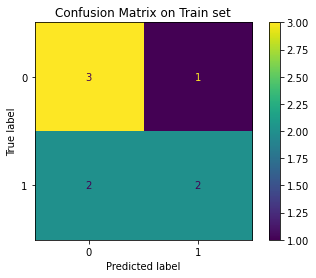

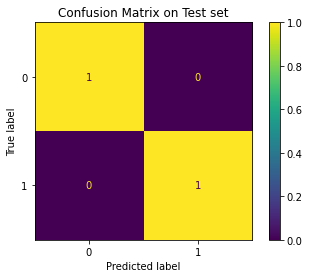

In [15]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

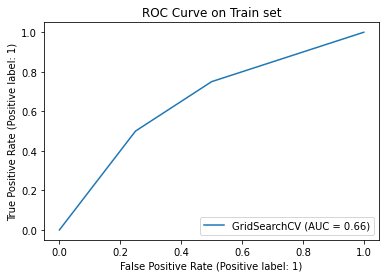

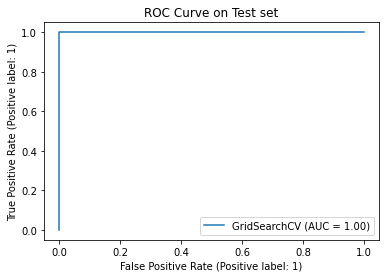

In [16]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

## Random Forest
Let's train a Random Forest (with hyperparameter optimization) and evaluate its performances :

### Training with hyperparameter optimization
For Random Forest, the hyperparameters that are important for overfitting are :
* min_samples_leaf
* min_samples_split
* max_depth
* n_estimators

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [17]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10}
Best validation accuracy :  0.5555555555555555


### Performances

In [18]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[1 1 0 1 0 1 1 1]

Probabilities on training set...
...Done.
[[0.4975     0.5025    ]
 [0.4975     0.5025    ]
 [0.59416667 0.40583333]
 [0.44416667 0.55583333]
 [0.62083333 0.37916667]
 [0.4775     0.5225    ]
 [0.36083333 0.63916667]
 [0.2775     0.7225    ]]



In [19]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[1 1]

Probabilities on test set...
...Done.
[[0.4975 0.5025]
 [0.4975 0.5025]]



In [20]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.75
accuracy on test set :  0.5

f1-score on training set :  0.8
f1-score on test set :  0.6666666666666666



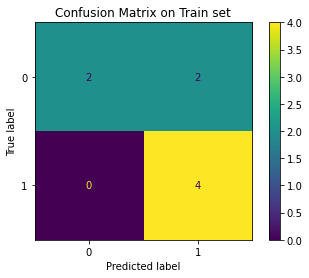

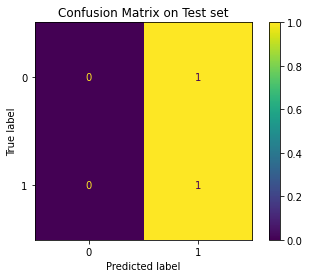

In [21]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

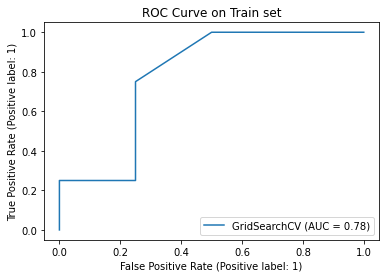

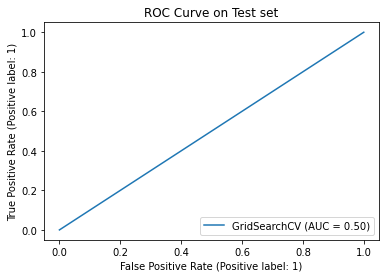

In [22]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

## Feature importance
All the classes from the module [sklearn.tree](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) have an attribute named `feature_importances_` that allows to get a ranking of the features once the model has been trained. Let's see an example of how to interpret these values obtained with the best `RandomForestClassifier`:

In [23]:
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Age', 'Salary', 'Country_Germany', 'Country_Spain']


In [24]:
# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearch.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

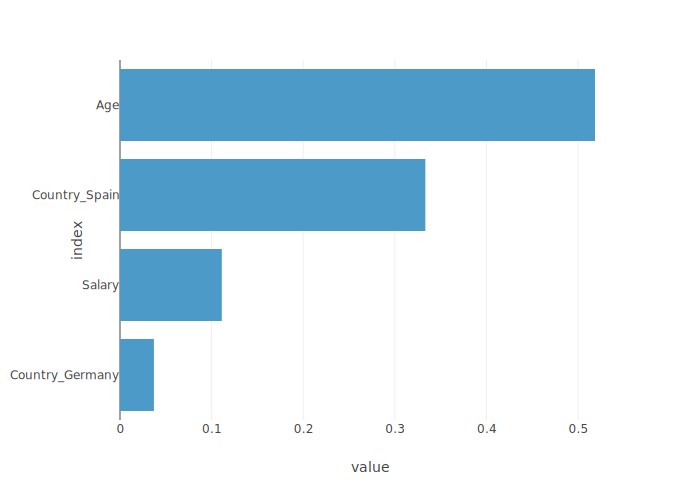

In [25]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

## Resources 📚📚

* [Decision trees in scikit-learn](https://scikit-learn.org/stable/modules/tree.html)